<a href="https://colab.research.google.com/github/katrin-nekhin/DaltoBoulder/blob/main/ImageProcessingExercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Climbing Route visualizer (for color blind)**

The code below attemps to preprocess a given wall image -
remove noise and smoothen the picture

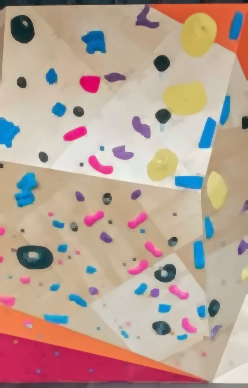

True

In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Read image
img = cv.imread('/content/drive/MyDrive/image processing projects/wall.jpg')

# Remove noise
img_nn = cv.fastNlMeansDenoisingColored(img)

# split image to B G R plains
bgr = cv.split(img_nn)

# Converting iamge to gray
img_gray = cv.cvtColor(img_nn, cv.COLOR_BGR2GRAY)

# Binirize image using OTSU threshold
ret,img_bin = cv.threshold(img_gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# To Smooth unwanted background details but preserve small holds,
# we are going to open and close each rgb channel with a 4x4 kernel
kernel = np.ones((3,3),np.uint8)

bgr_new = ()
for idx, color in enumerate(bgr):
  opening = cv.morphologyEx(color, cv.MORPH_OPEN, kernel)
  closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel)
  bgr_new += (closing,)

new_colored = cv.merge(bgr_new)

cv2_imshow(new_colored)

# Save new smothened image
cv.imwrite("smooth_wall.jpg",new_colored)

An attemp to see if I can find a threshold for each color in the picture and this way clasiffy each hold and mark all the routes
(didn't work)

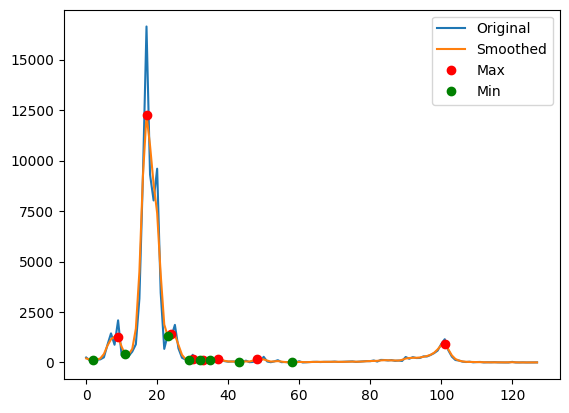

In [ ]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

h, s, v = cv.split(cv.cvtColor(new_colored, cv.COLOR_BGR2HSV))

hist_values, _ = np.histogram(h.ravel(), bins=128, range=(0, 127))
smoothed = gaussian_filter1d(hist_values, sigma=0.9)

plt.plot(hist_values, label="Original")
plt.plot(smoothed, label="Smoothed")

inv_hist = -np.array(smoothed)
max_p, props = find_peaks(smoothed, prominence=25)
min_p, props = find_peaks(inv_hist, prominence=25)
plt.plot(max_p, smoothed[max_p], "ro", label="Max")  # red dots on peaks
plt.plot(min_p, smoothed[min_p], "go", label="Min")  # red dots on peaks
plt.legend()
plt.show()

Idea: pre define colors in hue histogram (range(a,b)=red,range(c,d)=pink,etc.) And sort according to this

In the following point we'll peak a "start" hold and find the holds that belong to that route

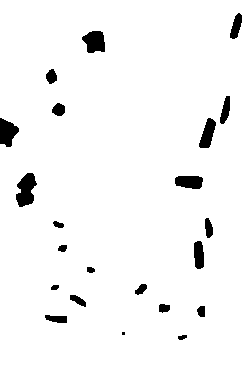

In [ ]:
img_rgb = cv.cvtColor(new_colored, cv.COLOR_BGR2RGB)
img_hsv = cv.cvtColor(new_colored, cv.COLOR_BGR2HSV)
h,s,v = cv.split(img_hsv)

x, y = 200, 248
bgr = new_colored[y, x]
target_hsv = cv.cvtColor(np.uint8([[bgr]]), cv.COLOR_BGR2HSV)[0][0]
target_h, target_s, target_v = target_hsv

for x in range(img_hsv.shape[0]):
    for y in range(img_hsv.shape[1]):
        if (
            abs(int(h[x, y]) - int(target_h)) < 50 and
            abs(int(s[x, y]) - int(target_s)) < 100 and
            abs(int(v[x, y]) - int(target_v)) < 100
        ):
            h[x, y], s[x, y], v[x, y] = 0, 0, 0  # black
        else:
            h[x, y], s[x, y], v[x, y] = 0, 0, 255  # white

new_hsv = cv.merge((h, s, v))
result_bgr = cv.cvtColor(new_hsv, cv.COLOR_HSV2BGR)
cv2_imshow(result_bgr)

Attempt to remove background

(388, 248)
[ 17  57 194]


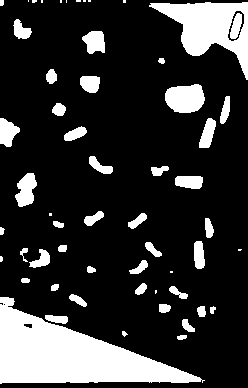

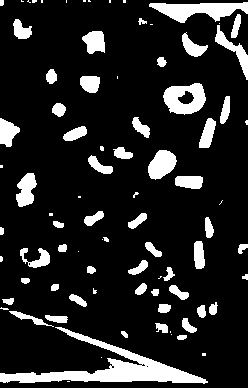

In [ ]:
#Most common Hue value in the picture
bg_h = np.argmax(hist_values)

#find 5 random
#bg_5p = np.random.randint(0,[new_colored.shape[0:1]],(5,2))
#print(bg_5p)
max_itter = 50
bg_median = np.array([17,0,0])
i = 0
print(new_colored.shape[0:2])
while i < max_itter:
  [x,y] = np.random.randint(0,new_colored.shape[0:2],2)
  if img_hsv[x][y][0] == bg_h:
    bg_median[1] += img_hsv[x][y][1]
    bg_median[2] += img_hsv[x][y][2]
    i+=1

bg_median[1:3] = np.uint8(bg_median[1:3]/max_itter)
print(bg_median)
target_hsv = bg_median

#mask
delta = np.array([50, 60, 60])
lower = np.clip(target_hsv - delta, 0, 255)
upper = np.clip(target_hsv + delta, 0, 255)

mask = cv.inRange(img_hsv, lower, upper)  # mask: 255 where match, 0 elsewhere

result_hsv = np.where(mask[:, :, None] == 255,
                      [0, 0, 255], # white in HSV
                      [0, 0, 0])   # black in HSV
result_hsv = result_hsv.astype(np.uint8)

result_bgr = cv.cvtColor(result_hsv, cv.COLOR_HSV2BGR)
#cv2_imshow(result_bgr)
#cv2_imshow(img_hsv[:,:,1])
ret,img_bin = cv.threshold(img_hsv[:,:,1],0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
img_bin2 = cv.adaptiveThreshold(img_hsv[:,:,1],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,75,-30)
cv2_imshow(img_bin)
cv2_imshow(img_bin2)

(734, 551)


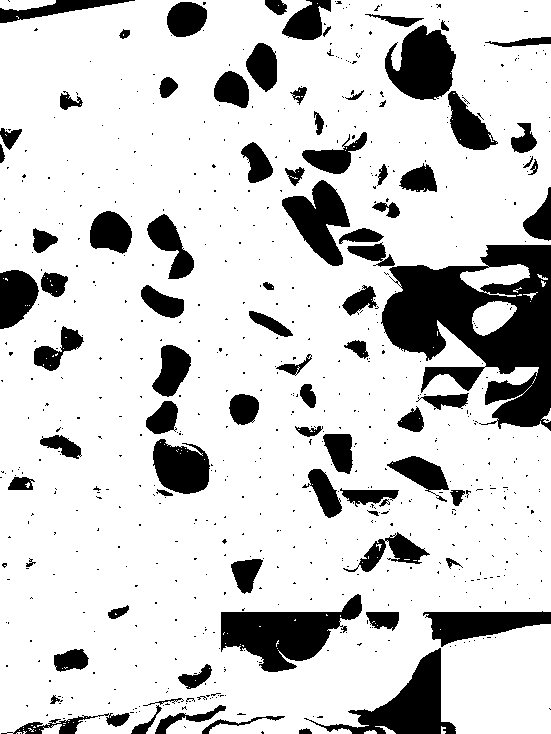

In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import math

# Read image
img = cv.imread('/content/drive/MyDrive/image processing projects/pics/wall1.jpg')
img = cv.resize(img, (0, 0), fx = 0.18, fy = 0.18)


# Converting iamge to gray
#img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Remove noise
img_nn = cv.fastNlMeansDenoisingColored(img,5,7)
img_hsv = cv.cvtColor(img_nn, cv.COLOR_BGR2HSV)


# Binirize image using OTSU threshold
#ret,img_bin = cv.threshold(img_nn,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

#cv2_imshow(np.hstack([img,img_nn]))
#cv2_imshow(np.hstack([img_gray]))

# To Smooth unwanted background details but preserve small holds,
# we are going to open and close each rgb channel with a 4x4 kernel
#kernel = np.ones((5,5),np.uint8)

#bgr_new = ()
#for idx, color in enumerate(bgr):
#  opening = cv.morphologyEx(color, cv.MORPH_OPEN, kernel)
#  closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel)
#  bgr_new += (closing,)

#new_colored = cv.merge(bgr_new)
#new_colored = cv.dilate(img_nn,    kernel=kernel)
result_hsv = np.empty(img_hsv.shape)
print((img_hsv.shape[0],img_hsv.shape[1]))
blocks_y = 6
blocks_x = 5
y1, x1 = [0, 0]
for i in range(1,blocks_x+1):
  y1 = 0
  x2 = math.ceil(i*(img_hsv.shape[1]/blocks_x))
  for j in range(1,blocks_y+1):
    y2 = math.ceil(j*(img_hsv.shape[0]/blocks_y))
    img_hsv_sl = img_hsv[y1:y2,x1:x2,:].astype(np.uint8)
    # split image to H S V plains
    hsv = cv.split(img_hsv_sl)
    target_color = np.empty(3)
    for idx, color in enumerate(hsv):
      hist_values, _ = np.histogram(color.ravel(), bins=256, range=(0, 255))
      target_color[idx] = np.argmax(hist_values)

    #mask
    delta = np.array([50, 100, 50])
    lower = np.clip(target_color - delta, 0, 255)
    upper = np.clip(target_color + delta, 0, 255)

    mask = cv.inRange(img_hsv_sl, lower, upper)  # mask: 255 where match, 0 elsewhere
    result_hsvij = np.where(mask[:  , :   , None ] == 255,
                            [255, 255 , 255  ], # white
                            [0  , 0   , 0    ]) # black


    result_hsv[y1:y2,x1:x2] = result_hsvij

    y1 = y2
  x1 = x2


cv2_imshow(result_hsv)
#cv2_imshow(h)



# Save new smothened image
#cv.imwrite("smooth_wall.jpg",new_colored)

K-means

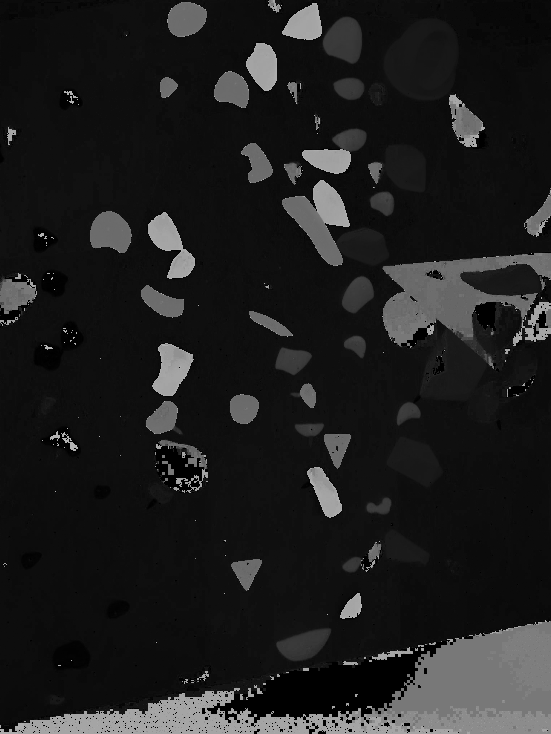

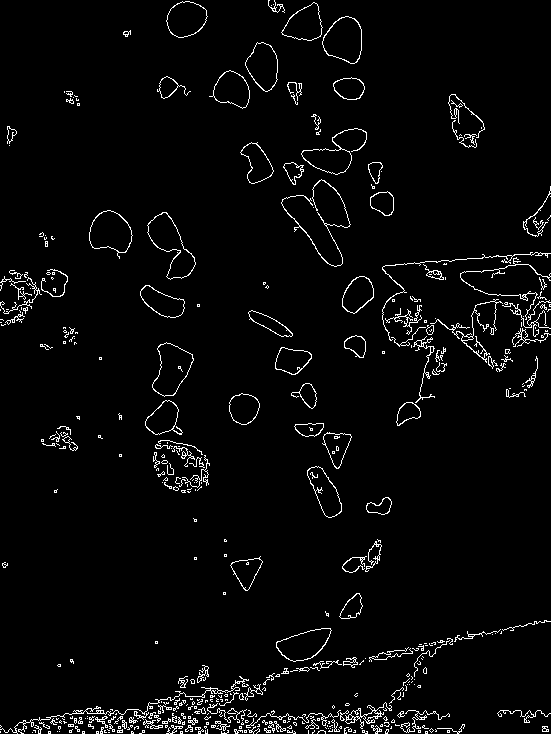

In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import math

# Read image
img = cv.imread('/content/drive/MyDrive/image processing projects/pics/wall1.jpg')
img = cv.resize(img, (0, 0), fx = 0.18, fy = 0.18)

# Remove noise
#img_nn = cv.fastNlMeansDenoisingColored(img,5,7)

# bilateralFilter blur (preserves edges)
#blur = cv.bilateralFilter(img,9,55,85)
blur = cv.GaussianBlur(img,(5,5),3)

blurred_gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

#cv2_imshow(blurred_gray)

edges = cv.Canny(blurred_gray, 50, 150)
edges = cv.dilate(edges, None)

#cv2_imshow(edges)

# Convert to HSV
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

h,s,v = cv.split(img_hsv)

kernel = np.ones((5,5),np.uint8)

morph = cv.morphologyEx(h, cv.MORPH_CLOSE, kernel)

cv2_imshow(h)

edges = cv.Canny(h, 10, 150)
cv2_imshow(edges)
